In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.stem.lancaster import LancasterStemmer
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm_notebook
import xgboost as xgb

from tools.data_cleansing import clean
from tools.data_exploration import print_email_by_id, emails_sent_distribution, emails_received_distribution,\
body_length_distribution, number_of_recipients_distribution
from tools.data_handling import enrich_emails, load_email_senders, unique_recipients, address_book, load_emails
from tools.features import split_tokenizer, TwidfVectorizer, TeamVectorizer, FastCountVectorizer
from tools.sender_pipeline import SenderModel
from tools.submission import save_submission
from tools.staff_graph import compute_summary_graph, construct_graph, compute_teams, assign_team

# Data loading and first look

In [2]:
df_emails = enrich_emails()

Reading dataframe from data/enrich_emails.csv


In [3]:
print_email_by_id(df_emails, 265949)

From: fletcher.j.sturm@enron.com
To: tamara.black@enron.com
On: 2001-01-24 10:10:00
Body:
    how about 3:15 or 3:30?fletch


In [4]:
df_email_senders = load_email_senders()

# Data exploration

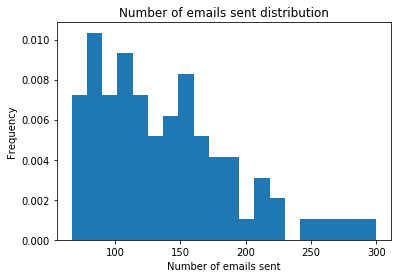

In [5]:
emails_sent_distribution(df_email_senders, max_value=300)

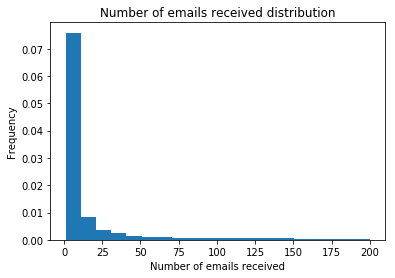

In [6]:
emails_received_distribution(df_emails, max_value=200)

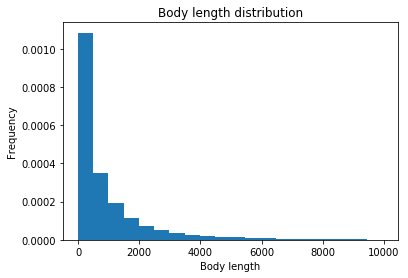

In [7]:
body_length_distribution(df_emails, max_value=10000)

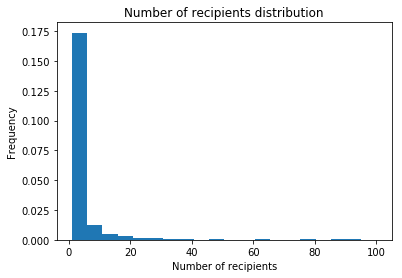

In [8]:
number_of_recipients_distribution(df_emails, bins=20, max_value=100)

In [9]:
unique_rec = unique_recipients(df_emails)
print("Number of unique recipients: {}".format(len(unique_rec)))

Number of unique recipients: 9779


In [10]:
df_emails[df_emails["sender"] == email]

NameError: name 'email' is not defined

# Testing TeamVectorizer

In [ ]:
team_vectorizer = TeamVectorizer()

In [ ]:
team_vectorizer.fit(df_emails)

In [ ]:
team_vectorizer.n_features

In [ ]:
a = team_vectorizer.transform(["steven.january@enron.com", "terry.kowalke@enron.com", "lynn.blair@enron.com"])

In [ ]:
b = team_vectorizer.transform(["rick.dietz@enron.com", "raetta.zadow@enron.com", "larry.berger@enron.com"])

# Data cleansing

## Cleansing function

In [13]:
def clean_df(df_emails, df_senders):
    df_emails["clean_body"] = ""
    for index, row in tqdm_notebook(df_senders.iterrows(), desc="Senders cleaning", total=df_senders.shape[0]):
        mids = list(map(int, row["mids"].split()))
        # data loading and separation
        df_interest = df_emails.ix[mids]
        # data cleansing
        unique_rec_train = unique_recipients(df_interest)
        add_book = address_book(unique_rec_train)
        df_emails.loc[mids, "clean_body"] = df_interest["body"].apply(lambda x: clean(x, add_book))
    df_emails["clean_body"] = df_emails["clean_body"].fillna("")

In [14]:
clean_df(df_emails, df_email_senders)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [15]:
df_emails[df_emails["body"].str.contains("Forwarded by")].head(20)

,date,body,recipients,sender,clean_body
mid,,,,,
132,2000-08-27 23:11:00,Check this out. I think that we need to be si...,robert.badeer@enron.com greg.wolfe@enron.com l...,tim.belden@enron.com,check think nee sign
466,2000-08-14 23:23:00,"Please see the attached. Christian, could you...",robert.badeer@enron.com christian.yoder@enron.com,tim.belden@enron.com,pleas see attach christian could coordin writ let
510,2000-07-31 23:32:00,i would categorize things in the following man...,robert.badeer@enron.com jeff.dasovich@enron.co...,tim.belden@enron.com,would categ thing follow man day ahead market ...
514,2000-08-08 02:51:00,put this into the congestion redesign file if ...,robert.badeer@enron.com,tim.belden@enron.com,put congest redesign fil alread forward tim be...
1019,2001-07-31 08:27:11,"Kevin, as promised, attached is the informatio...",kevin.hyatt@enron.com,larry.f.campbell@enron.com,kevin prom attach inform found david roensch e...
1083,2001-02-22 04:40:33,---------------------- Forwarded by Darrell Sc...,kevin.hyatt@enron.com ronald.matthews@enron.co...,darrell.schoolcraft@enron.com,forward darrell schoolcraft et enron ben asant...
2947,2001-03-01 12:24:00,Does anyone have any issues or ideas on how EE...,paul.kaufman@enron.com alan.comnes@enron.com r...,james.d.steffes@enron.com,anyon issu idea ee best work ap jim
2973,2001-03-06 22:38:00,"Sue, Alan, Mary --Can the three of you determi...",susan.mara@enron.com alan.comnes@enron.com ste...,james.d.steffes@enron.com,sue alan mary three determin best cov report e...
2984,2001-03-07 22:47:00,FYI. QFs are beginning to stop operating due ...,susan.mara@enron.com rlichtenstein@marathon-co...,james.d.steffes@enron.com,fyi qfs begin stop op due non pay addit enron ...


# Training

In [16]:
df_small_senders = df_email_senders.sample(frac=0.3, random_state=0)

In [17]:
team_vectorizer = TeamVectorizer()
team_vectorizer.fit(df_emails)

## Current Model

In [18]:
def model(df_interest, n_mails):
    # Input TF-IDF vectorizer
    input_bow = FastCountVectorizer()
    # Random Forest Regressor
    rf = RandomForestRegressor(
        n_estimators=190,
        max_depth=75,
        n_jobs=-1,
        min_samples_leaf=max(1,int(0.0002*n_mails)),
        max_features="sqrt",
        random_state=0)
    # Output vectorizer
    unique_rec = unique_recipients(df_interest)
    output_bow = CountVectorizer(
        tokenizer=split_tokenizer,
        vocabulary=unique_rec)
    # Sender Model
    sender_model = SenderModel(
        df_emails=df_interest,
        classifier = rf,
        input_vectorizer = input_bow,
        output_vectorizer = output_bow
    )
    return sender_model

## On one particular sender

In [19]:
row = df_email_senders.iloc[0]
mids = list(map(int, row["mids"].split()))
df_interest = df_emails.ix[mids]
n_mails = len(mids)
sender_model = model(df_interest, n_mails)
prec = sender_model.evaluate(team_vectorizer, random_state=0)
print(prec)

0.602234012399


## Evaluation

In [20]:
df_precision = pd.DataFrame(columns=["sender", "n_mails", "precision"])

In [21]:
for index, row in tqdm_notebook(df_email_senders.iterrows(), desc="Senders evaluation", total=df_email_senders.shape[0]):
    # Row unpacking
    sender = row["sender"]
    mids = list(map(int, row["mids"].split()))
    df_interest = df_emails.ix[mids]
    n_mails = len(mids)
    # Model building
    sender_model = model(df_interest, n_mails)
    # Precision computation
    prec = sender_model.evaluate(team_vectorizer, random_state=0)
    df_precision.loc[index] = [sender, n_mails, prec]

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
/Users/Mazz/Documents/MVA/S2-ALTEGRAD/email-classification-challenge/tools/sender_pipeline.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.classifier.fit(X_train, Y_train.toarray())
/Users/Mazz/Documents/MVA/S2-ALTEGRAD/email-classification-challenge/tools/sender_pipeline.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.classifier.fit(X_train, Y_train.toarray())
/Users/Mazz/Documents/MVA/S2-ALTEGRAD/email-classification-challenge/tools/sender_pipeline.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape o

In [22]:
prec

0.39566269841269863

In [23]:
(df_precision["precision"]*df_precision["n_mails"]).sum()/(df_precision["n_mails"].sum())

0.39926773828003143

# Submission

## Actual model training

In [ ]:
sender_models = dict()
for index, row in tqdm_notebook(df_email_senders.iterrows(), desc="Senders Training (submision)", total=df_email_senders.shape[0]):
    # Row unpacking
    sender = row["sender"]
    mids = list(map(int, row["mids"].split()))
    df_interest = df_emails.ix[mids]
    n_mails = len(mids)
    # Model building
    sender_model = model(df_interest, n_mails)
    # Training
    sender_model.train()
    # Saving
    sender_models[sender] = sender_model

## Data loading

In [ ]:
df_submission_senders = load_email_senders(set_type="test")
df_submission = load_emails(set_type="test")
df_submission["recipients"] = ""

## Data cleansing

In [ ]:
clean_df(df_submission, df_submission_senders)

## Prediction

In [ ]:
for index, row in tqdm_notebook(df_submission_senders.iterrows(), desc="Senders predictions", total=df_submission_senders.shape[0]):
    sender = row["sender"]
    mids = map(int, row["mids"].split())
    # Model loading
    sender_model = sender_models[sender]
    # Prediction
    sender_model.predict(mids, df_submission)

# Fine tuning

In [ ]:
from tools.fine_tuning import expected_precision

In [ ]:
depths = [2, 5, 10, 15, 20, 30, 50, 100, 300]
n = len(depths)
p = np.zeros(n)

In [ ]:
for i, depth in enumerate(depths):
    p[i] = expected_precision(min_sample_prop=0.0002,
                             n_estimators=15,
                             max_depth=100)

In [ ]:
n_trials = 10
pr = np.zeros(n_trials)
for i in range(n_trials):
    pr[i] += expected_precision(min_sample_prop=0.04,
                             n_estimators=15,
                             max_depth=30)
print(pr)

In [ ]:
pr.mean()

In [ ]:
plt.plot(depths, p)
plt.xlabel("Number of trees")
plt.ylabel("Precision")

## Formatting

In [ ]:
save_submission(df_submission,
               algo="RF single sender regressor tw idf",
               member="Zac")

In [ ]:
df_submission